In [1]:
# remember to remove this
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Part II: Concrete Slump Test

We aim to predict the 28-day Compressive Strength (MPA) value, using the train model on the other 7 feature variables.

**Loading and Inspecting the Data**

In [2]:
# remember to change to the same directory
slump_data = pd.read_csv("../datasets/slump_test.data")
slump_data

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82
...,...,...,...,...,...,...,...,...,...,...,...
98,99,248.3,101.0,239.1,168.9,7.7,954.2,640.6,0.0,20.0,49.97
99,100,248.0,101.0,239.9,169.1,7.7,949.9,644.1,2.0,20.0,50.23
100,101,258.8,88.0,239.6,175.3,7.6,938.9,646.0,0.0,20.0,50.50
101,102,297.1,40.9,239.9,194.0,7.5,908.9,651.8,27.5,67.0,49.17


In [3]:
# Check for any missing values in the dataset
null_count = np.array(slump_data.isnull().sum())
na_counts = np.array(slump_data.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=slump_data.columns, index=['null_count','na_counts'])

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
null_count,0,0,0,0,0,0,0,0,0,0,0
na_counts,0,0,0,0,0,0,0,0,0,0,0


Looks like our data is clean, with no NA or null values, so no need to impute or remove any rows. However, we do want to partition the dataset to include only the columns that are relevant to us. The columns to drop are:
- No (Index)
- SLUMP
- FLOW

A visual inspection of the dataset allows us to identify what index the columns are and remove them

In [4]:
# Take the first 7, excluding the index and the last dependent variable
def data_selection(dataset):
    X = dataset.iloc[:,1:8]
    y = dataset.iloc[:,-1]
    return(X,y)

X,y = data_selection(slump_data)

# Splitting the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5508)

**Voting Regressor - Linear SVM Regressor, LinReg, SGD Regressor**

Before we proceed, because we are using a SVM method, we require scaling on the data before proceeding to fit any regression models.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
std_scaler = StandardScaler() # call the scaler function

num_pipeline = Pipeline([ # pipeline for scaling the data
    ('std_scaler', StandardScaler())
])

In [6]:
# scale the data first
X_train_scaled = pd.DataFrame(num_pipeline.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(num_pipeline.fit_transform(X_test), columns=X_train.columns)

In [7]:
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error

# call the regression models, then put them into the voting regressor
lin_svr = LinearSVR()
lin_reg = LinearRegression()
sgd_reg = SGDRegressor()

voting_reg = VotingRegressor(estimators=[
    ('Linear SVM', LinearSVR()),
    ('Linear Regression', LinearRegression()),
    ('SGD Regression', SGDRegressor())
])

In [8]:
np.random.seed(5508)
# train the models, get both train and test RMSE
base_test_rsme = []
for reg in (lin_svr, lin_reg, sgd_reg, voting_reg):
    reg.fit(X_train_scaled, y_train)
    y_pred_train = reg.predict(X_train_scaled)
    y_pred_test = reg.predict(X_test_scaled)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    base_test_rsme.append(rmse_test)
    print(f'{reg.__class__.__name__} - RMSE train: {rmse_train}, RMSE test: {rmse_test}')

LinearSVR - RMSE train: 2.8571086002708794, RMSE test: 3.339646492009573
LinearRegression - RMSE train: 2.3520029517363343, RMSE test: 3.534364825114908
SGDRegressor - RMSE train: 2.3550422325832954, RMSE test: 3.487518263072861
VotingRegressor - RMSE train: 2.4157808997571326, RMSE test: 3.3604607760222205


RMSE between the 4 regression models, show not much difference between them. The voting regressor, which is supposed to provide a more accurate prediciton, which takes the average of the 3 models, which improves the generalisability of the models. However, we can see that the RMSE of the Voting Regressor is not the best out of the 4, with the Linear SVR having a lower score.

In [9]:
# get predicted values for all 4 models
pred_lin_svr = lin_svr.predict(X_test_scaled)
pred_lin_reg = lin_reg.predict(X_test_scaled)
pred_sgd_reg = sgd_reg.predict(X_test_scaled)
pred_voting_reg = voting_reg.predict(X_test_scaled)

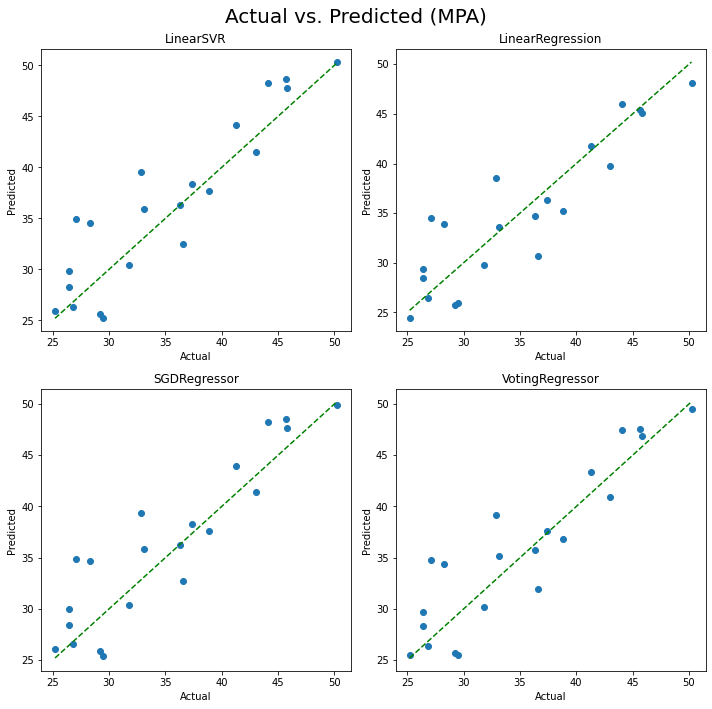

In [10]:
# Create subplots for all 4 regression models
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(y_test, pred_lin_reg)
axs[0, 1].scatter(y_test, pred_lin_svr)
axs[1, 0].scatter(y_test, pred_sgd_reg)
axs[1, 1].scatter(y_test, pred_voting_reg)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
        axs[i, j].set_xlabel('Actual')
        axs[i, j].set_ylabel('Predicted')

axs[0, 0].set_title('LinearSVR')
axs[0, 1].set_title('LinearRegression')
axs[1, 0].set_title('SGDRegressor')
axs[1, 1].set_title('VotingRegressor')

fig.suptitle('Actual vs. Predicted (MPA)',fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 1])

Looking at the 4 plots above, we can see that the 4 models are quite similar in terms of deviations from the perfect line, but perhaps we can visualise this better by putting them all into a single plot and color coding them.

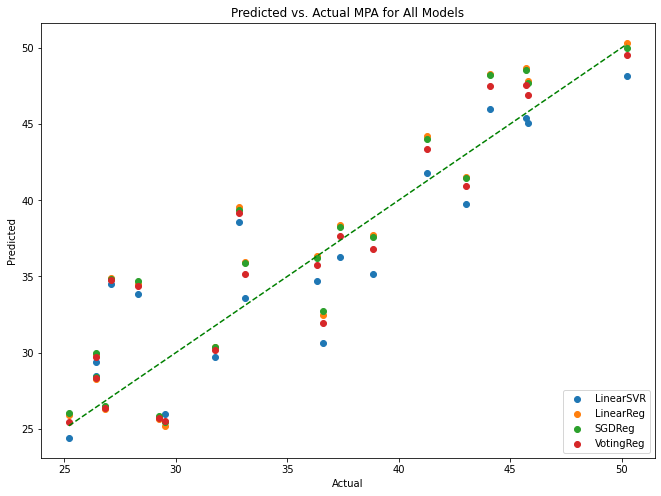

In [11]:
# color coded predicted vs actual
plt.figure(figsize=(11,8))
plt.scatter(y_test, pred_lin_svr, label="LinearSVR")
plt.scatter(y_test, pred_lin_reg, label="LinearReg")
plt.scatter(y_test, pred_sgd_reg, label="SGDReg")
plt.scatter(y_test, pred_voting_reg, label="VotingReg")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
plt.legend(loc="lower right")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual MPA for All Models')
plt.show()

We can observe that all 4 models, looking at the predicted vs actual plots, as well as the test RMSE from above, generally all perform quite close to each other. The plot above shows us that the variation between the predicted scores for each of the instances do not vary greatly, as suspected in the previous plot.

The green diagonal 45 degree dotted line indicates a perfect prediction for any points that fall on that line, and it seems like the models could be improved futher to reduce the error between the actual and predicted values. 

**Voting Regressor II - Tuned Base Estimators**

In [12]:
from sklearn.model_selection import GridSearchCV

# define the paramters to be searched for the SVR
grid_params_SVR = {'epsilon':np.arange(0,2,0.1),
               'C':np.arange(0.1,3,0.1)} 

# default values for all the hyperparams
lin_svr = LinearSVR(random_state=5508)
grid_search = GridSearchCV(lin_svr, grid_params_SVR, cv=3)
grid_search.fit(X_train_scaled, y_train)
svr_optimal = grid_search.best_params_
svr_optimal, grid_search.best_score_

({'C': 2.9000000000000004, 'epsilon': 0.2}, 0.8487565295697607)

In [13]:
grid_params_SGR = {'eta0':np.arange(0.01,0.2,0.001)} 

lin_sgd = SGDRegressor(random_state=5508)
grid_search = GridSearchCV(lin_sgd, grid_params_SGR, cv=3)
grid_search.fit(X_train_scaled, y_train)

sgr_optimal = grid_search.best_params_
sgr_optimal, grid_search.best_score_

({'eta0': 0.19899999999999984}, 0.8782154638706893)

Tuned Base Estimators with Optimal Hyperparameters:

- SVR Optimal Hyperparameters: epsilon = 0, C (regularization parameter) = 3.4
- Linear Regression OLS, no hyperparameters, retain previous model
- Stochastic GD Regression: eta0 (learning rate) = 0.19

In [14]:
# call the regression models, then put them into the voting regressor
lin_svr = LinearSVR(C=svr_optimal['C'], epsilon=svr_optimal['epsilon'],random_state=5508)
lin_reg = LinearRegression()
sgd_reg = SGDRegressor(eta0=sgr_optimal['eta0'],random_state=5508)

voting_reg = VotingRegressor(estimators=[
    ('Linear SVM', lin_svr),
    ('Linear Regression', lin_reg),
    ('SGD Regression', sgd_reg)
])

In [15]:
np.random.seed(5508)
opt_test_rmse = []
# train the models, get both train and test RMSE
for reg in (lin_svr, lin_reg, sgd_reg, voting_reg):
    reg.fit(X_train_scaled, y_train)
    y_pred_train = reg.predict(X_train_scaled)
    y_pred_test = reg.predict(X_test_scaled)
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    opt_test_rmse.append(rmse_test)
    print(f'{reg.__class__.__name__} - RMSE train: {rmse_train}, RMSE test: {rmse_test}')

LinearSVR - RMSE train: 2.495150668386012, RMSE test: 3.308783700100647
LinearRegression - RMSE train: 2.3520029517363343, RMSE test: 3.534364825114908
SGDRegressor - RMSE train: 2.48242390025564, RMSE test: 3.3361684388828663
VotingRegressor - RMSE train: 2.3773023553611368, RMSE test: 3.3319078262282726


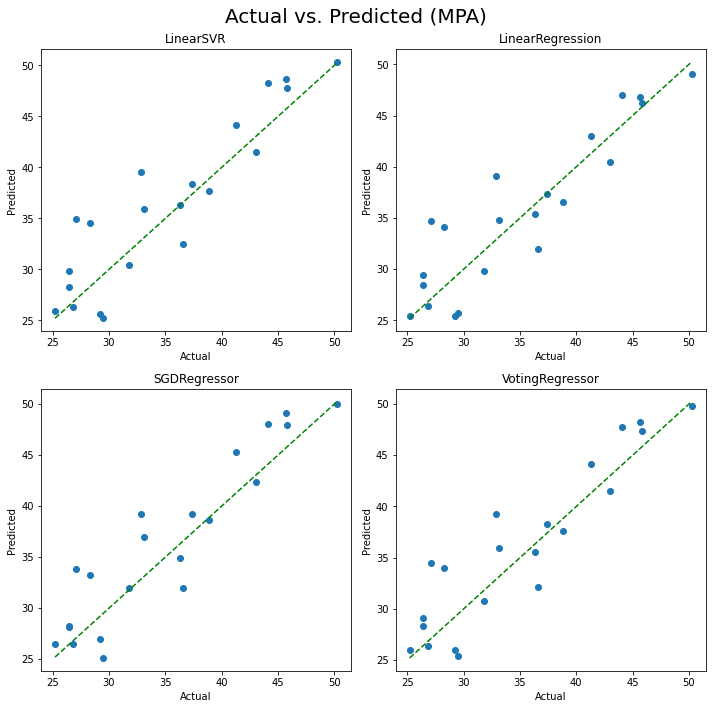

In [16]:
# Create subplots for all 4 regression models
# get predicted values for all 4 models
pred_lin_svr = lin_svr.predict(X_test_scaled)
pred_lin_reg = lin_reg.predict(X_test_scaled)
pred_sgd_reg = sgd_reg.predict(X_test_scaled)
pred_voting_reg = voting_reg.predict(X_test_scaled)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(y_test, pred_lin_reg)
axs[0, 1].scatter(y_test, pred_lin_svr)
axs[1, 0].scatter(y_test, pred_sgd_reg)
axs[1, 1].scatter(y_test, pred_voting_reg)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
        axs[i, j].set_xlabel('Actual')
        axs[i, j].set_ylabel('Predicted')

axs[0, 0].set_title('LinearSVR')
axs[0, 1].set_title('LinearRegression')
axs[1, 0].set_title('SGDRegressor')
axs[1, 1].set_title('VotingRegressor')

fig.suptitle('Actual vs. Predicted (MPA)',fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 1])

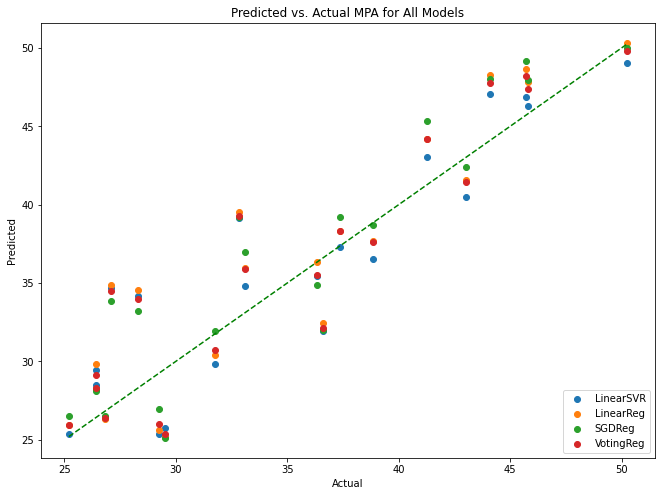

In [17]:
# color coded predicted vs actual
plt.figure(figsize=(11,8))
plt.scatter(y_test, pred_lin_svr, label="LinearSVR")
plt.scatter(y_test, pred_lin_reg, label="LinearReg")
plt.scatter(y_test, pred_sgd_reg, label="SGDReg")
plt.scatter(y_test, pred_voting_reg, label="VotingReg")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'g--')
plt.legend(loc="lower right")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual MPA for All Models')
plt.show()

In [18]:
pd.DataFrame([base_test_rsme, opt_test_rmse], columns=['SVR','LR','SGD','Voting'], index=['Base RMSE','Optimal RMSE'])

,SVR,LR,SGD,Voting
Base RMSE,3.339646,3.534365,3.487518,3.360461
Optimal RMSE,3.308784,3.534365,3.336168,3.331908


#### Conclusion:

--Do write up by Wednesday--